### Libraries

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler,StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import recall_score,roc_auc_score, classification_report,confusion_matrix 
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout,GRU
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold

In [2]:
train = pd.read_csv('train_s3TEQDk.csv')
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
test = pd.read_csv('test_mSzZ8RL.csv')
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [4]:
print(train.shape)
print(test.shape)

(245725, 11)
(105312, 10)


<AxesSubplot:xlabel='Is_Lead', ylabel='count'>

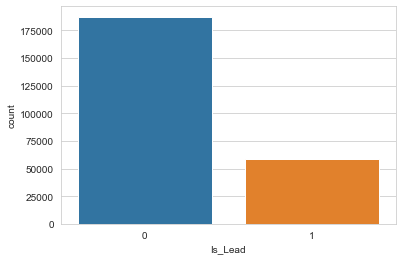

In [26]:
sns.set_style('whitegrid')
sns.countplot(x='Is_Lead',data=train)

In [15]:
train.Is_Lead.value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

In [ ]:
187437/train.shape[0]

### Class Imbalance Problem
In the train dataset, we have 3,749 (76.3%) sentiments labeled as positive, and 1,58 (23.7%) sentiments labeled as Neutral and 93(~2.35%) sentiments as Negative. So, it is an imbalanced classification problem.


In [42]:
combi = train.iloc[:,:-1].append(test, ignore_index=True)
combi.drop(['ID'],axis=1,inplace=True)
combi.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Female,73,RG268,Other,X3,43,No,1045696,No
1,Female,30,RG277,Salaried,X1,32,No,581988,No
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes
3,Male,34,RG270,Salaried,X1,19,No,470454,No
4,Female,30,RG282,Salaried,X1,33,No,886787,No


In [20]:
combi.shape

(351037, 10)

In [19]:
combi.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         41847
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

Roughly 12 percent of the Credit_Product data is missing

In [45]:
train.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [24]:
combi.describe(include='all')

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
count,351037,351037,351037.000000,351037,351037,351037,351037.000000,309190,3.510370e+05,351037
unique,351037,2,NaN,35,4,4,NaN,2,NaN,2
top,HIZXB8TP,Male,NaN,RG268,Self_Employed,X1,NaN,No,NaN,No
freq,1,191902,NaN,51059,144078,148202,NaN,205965,NaN,214087
mean,NaN,NaN,43.860716,NaN,NaN,NaN,46.924244,NaN,1.130141e+06,NaN
std,NaN,NaN,14.841932,NaN,NaN,NaN,32.329303,NaN,8.569530e+05,NaN
min,NaN,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,2.079000e+04,NaN
25%,NaN,NaN,30.000000,NaN,NaN,NaN,20.000000,NaN,6.041850e+05,NaN
50%,NaN,NaN,43.000000,NaN,NaN,NaN,32.000000,NaN,8.951620e+05,NaN
75%,NaN,NaN,54.000000,NaN,NaN,NaN,73.000000,NaN,1.368152e+06,NaN


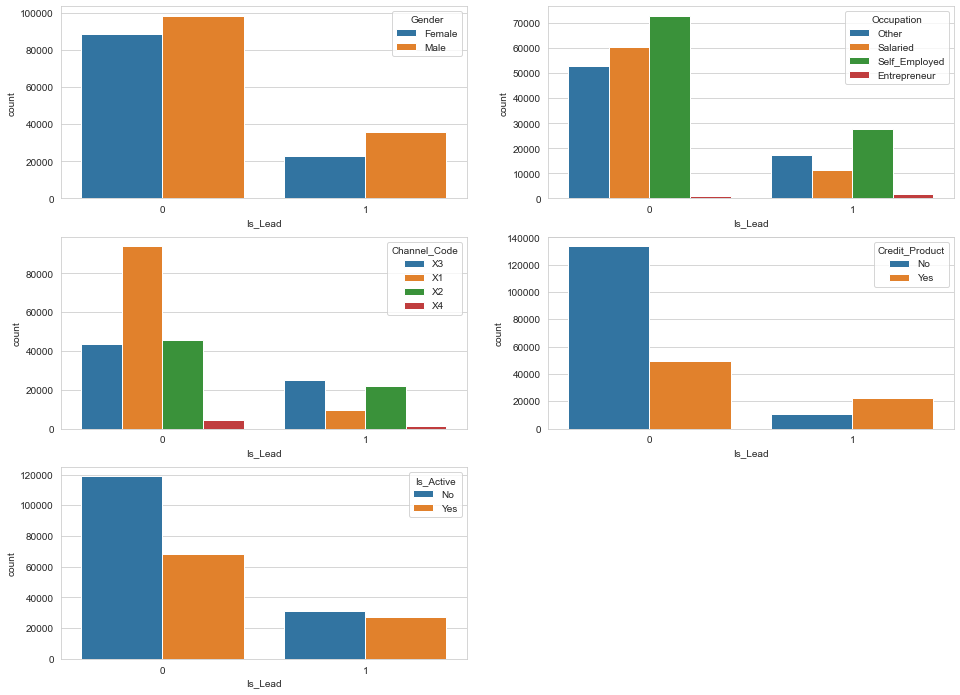

In [48]:
df = ['Gender', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
fig = plt.figure(figsize=(16,12))

for i in range(1,6):
    plt.subplot(3,2,i)
    sns.countplot(x='Is_Lead', hue=df[i-1],data=train)
    


We can see that Credit_Product column is mostly No when Is_Lead column is 0.

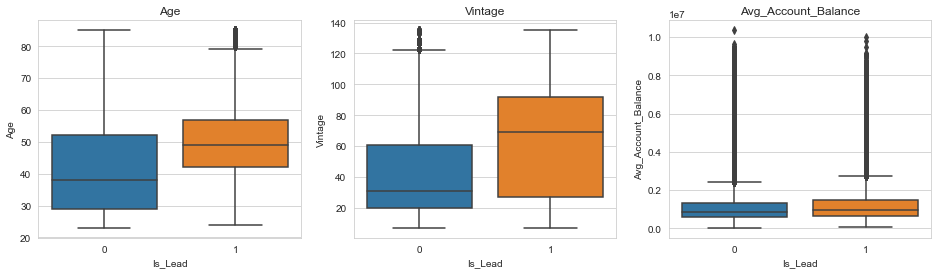

In [75]:
df = ['Age','Vintage','Avg_Account_Balance']
fig = plt.figure(figsize=(16,4))

for i in range(1,4):
    plt.subplot(1,3,i)
    plt.title(df[i-1])
    sns.boxplot(x='Is_Lead',y=df[i-1],data=train)
    


We can see that Avg_Account_balance column mostly have outliers.

In [81]:
print(train[train.Age>60].shape[0])
print(train[train.Vintage>70].shape[0])

34598
63866


In [82]:
print(combi[combi.Age>60].shape[0])
print(combi[combi.Vintage>70].shape[0])

49514
91108


<AxesSubplot:>

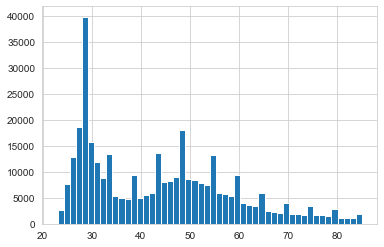

In [112]:
combi.Age.hist(bins=50)

<AxesSubplot:>

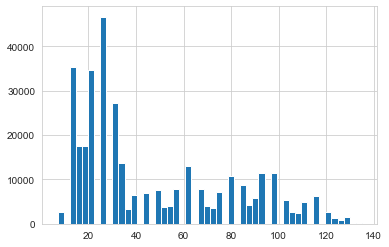

In [113]:
combi.Vintage.hist(bins=50)

<AxesSubplot:>

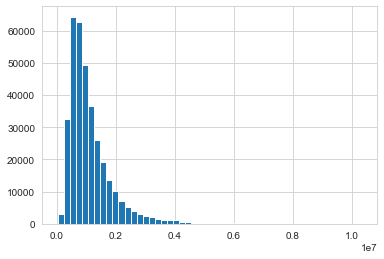

In [114]:
combi.Avg_Account_Balance.hist(bins=50)

C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 864x360 with 0 Axes>

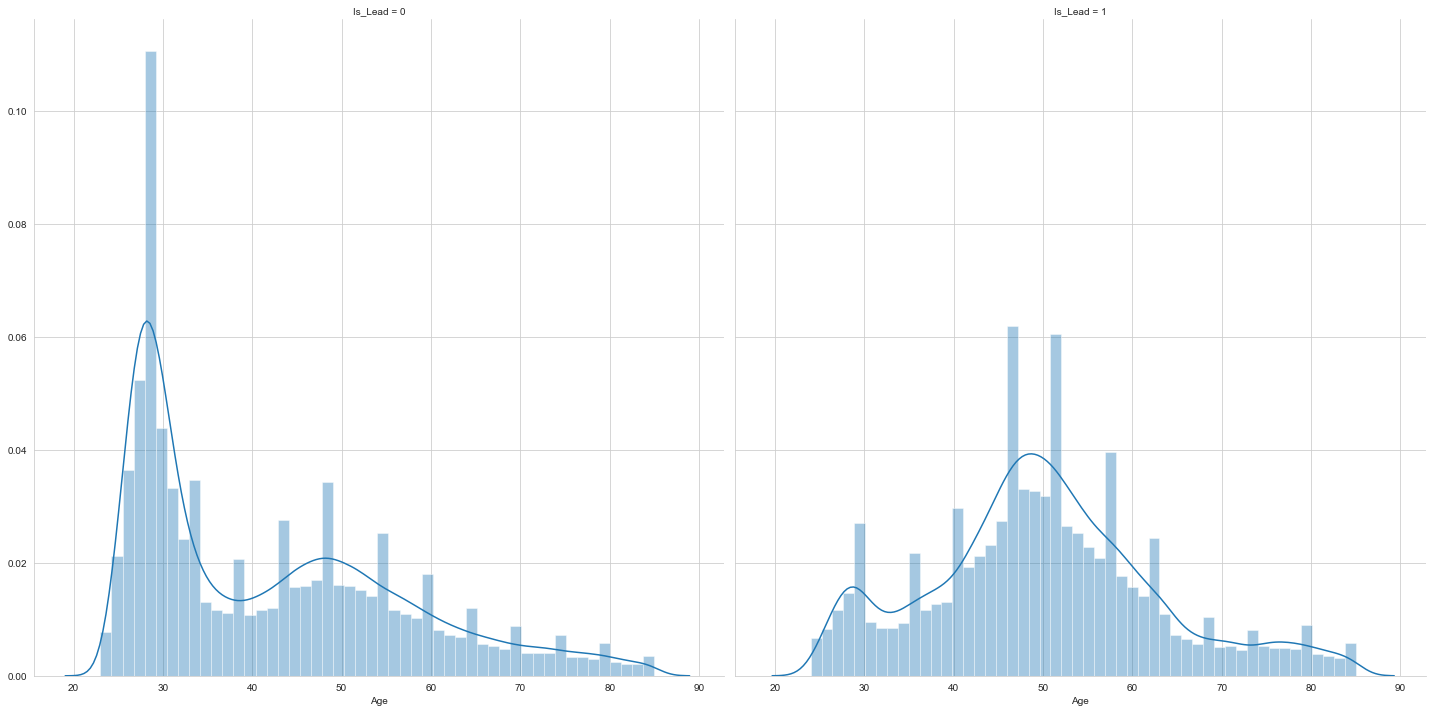

In [53]:
plt.figure(figsize=(12,5))
g = sns.FacetGrid(train, col='Is_Lead',size=10)
g = g.map(sns.distplot, "Age")
plt.show()

C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 864x360 with 0 Axes>

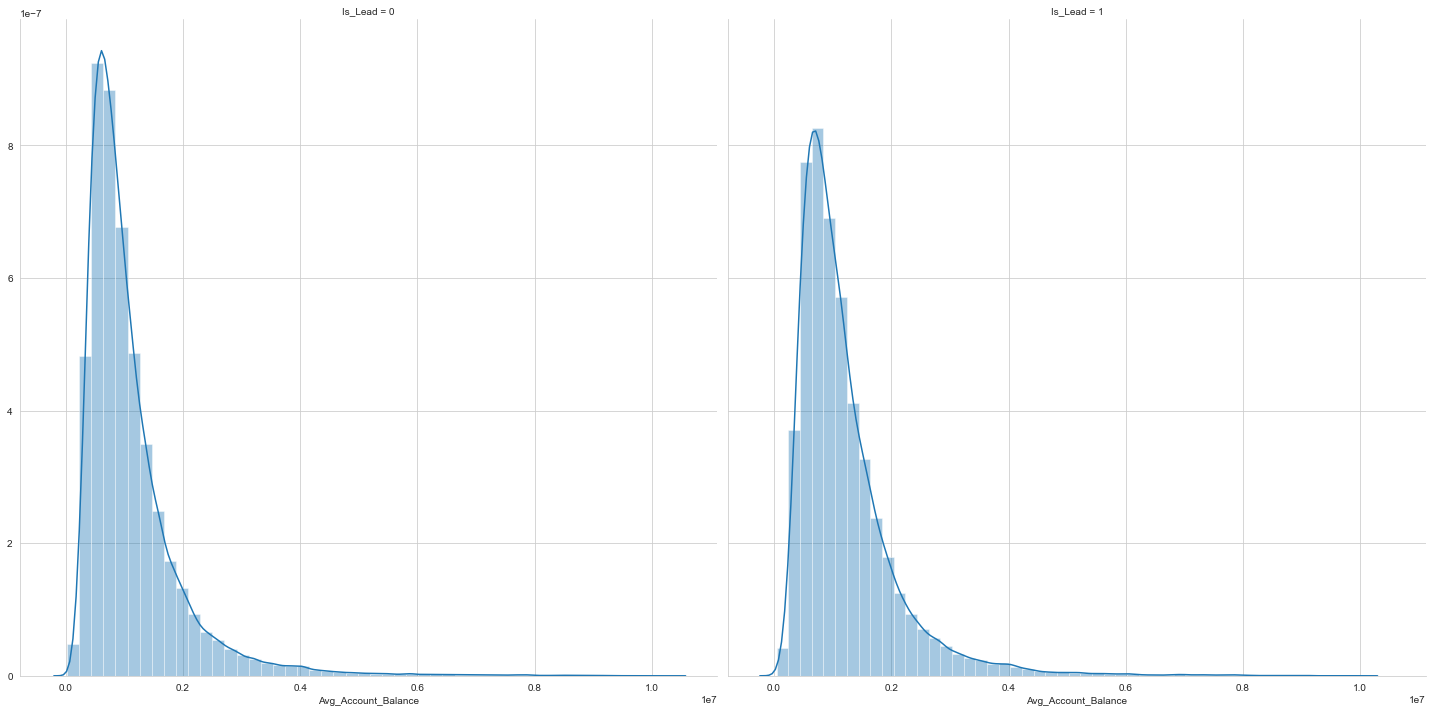

In [54]:
plt.figure(figsize=(12,5))
g = sns.FacetGrid(train, col='Is_Lead',size=10)
g = g.map(sns.distplot, "Avg_Account_Balance")
plt.show()

C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vidya\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 864x360 with 0 Axes>

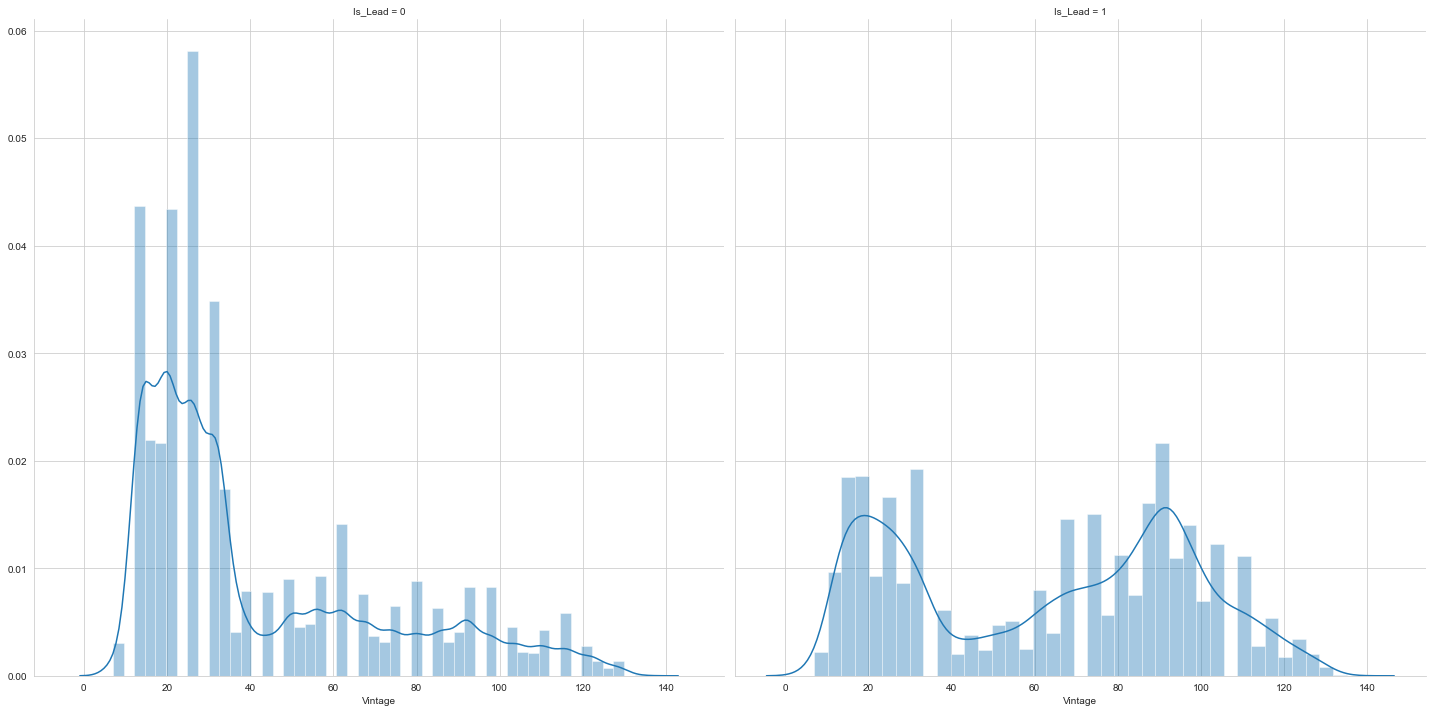

In [55]:
plt.figure(figsize=(12,5))
g = sns.FacetGrid(train, col='Is_Lead',size=10)
g = g.map(sns.distplot, "Vintage")
plt.show()

<Figure size 1152x864 with 0 Axes>

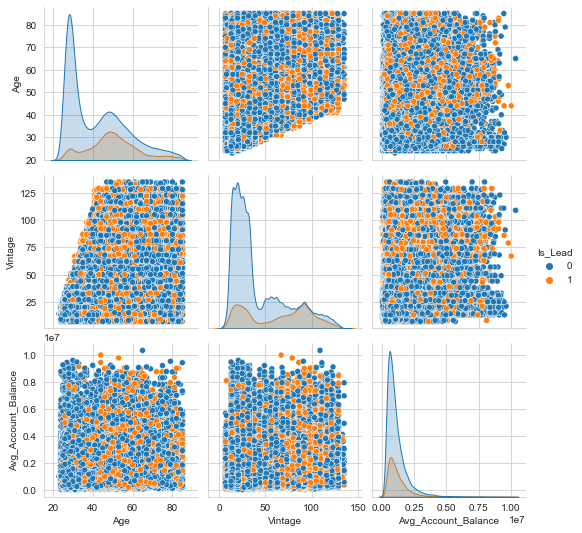

In [101]:
fig = plt.figure(figsize=(16,12))
sns.pairplot(train[['Age','Vintage','Avg_Account_Balance','Is_Lead']], hue = 'Is_Lead')

### Missing Values Treatment
Method 1 - Use NaN as 'Other'<br>
Method 2 - Use ML Algo

#### Method 1

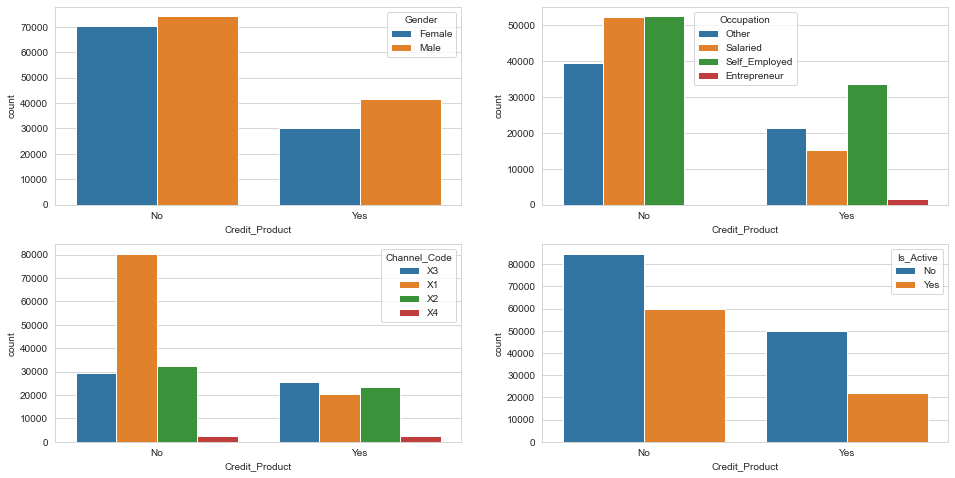

In [73]:
#without "Other"
df = ['Gender', 'Occupation', 'Channel_Code', 'Is_Active']
fig = plt.figure(figsize=(16,8))

for i in range(1,5):
    plt.subplot(2,2,i)
    sns.countplot(x='Credit_Product', hue=df[i-1],data=combi)

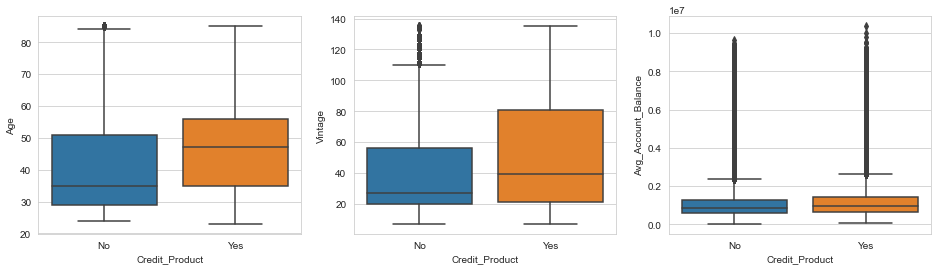

In [74]:
df = ['Age','Vintage','Avg_Account_Balance']
fig = plt.figure(figsize=(16,4))

for i in range(1,4):
    plt.subplot(1,3,i)
#     plt.titile()
    sns.boxplot(x='Credit_Product',y=df[i-1],data=combi)

<Figure size 1152x864 with 0 Axes>

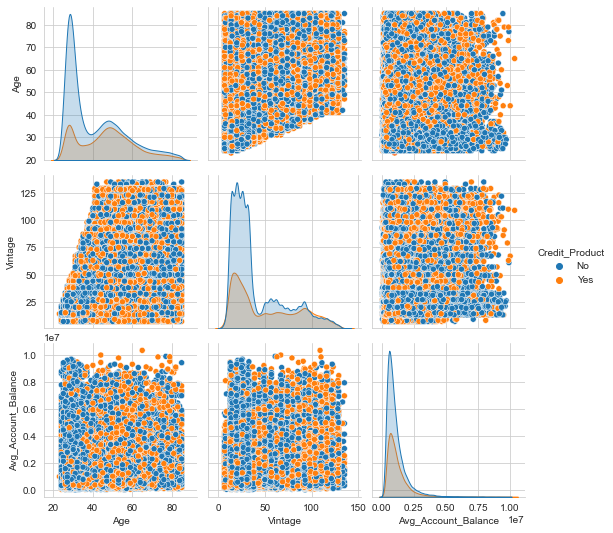

In [103]:
fig = plt.figure(figsize=(16,12))
sns.pairplot(combi[['Age','Vintage','Avg_Account_Balance','Credit_Product']], hue = 'Credit_Product')

In [173]:
combi['Credit_Product_1'] = combi.Credit_Product

In [154]:
combi.Credit_Product_1.unique()

array(['Yes', 'Other'], dtype=object)

In [43]:
#with "Other"
combi['Credit_Product'] = combi.Credit_Product.fillna('Other')
# combi['Credit_Product_1'] = combi.Credit_Product_1.replace({'No':'Yes'})
# df = ['Gender', 'Occupation', 'Channel_Code', 'Is_Active']
# fig = plt.figure(figsize=(16,8))

# for i in range(1,5):
#     plt.subplot(2,2,i)
#     sns.countplot(x='Credit_Product_1', hue=df[i-1],data=combi)

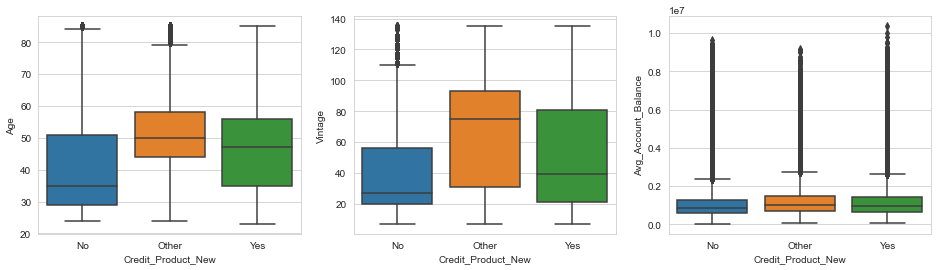

In [87]:
df = ['Age','Vintage','Avg_Account_Balance']
fig = plt.figure(figsize=(16,4))

for i in range(1,4):
    plt.subplot(1,3,i)
#     plt.titile()
    sns.boxplot(x='Credit_Product_New',y=df[i-1],data=combi)

#### Method2

In [149]:
df=pd.get_dummies(data=combi[['Gender', 'Occupation', 'Channel_Code', 'Is_Active']],drop_first=True)
df.head()

,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes
0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,1
3,1,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [150]:
combi = pd.concat([combi.drop(['Gender', 'Occupation', 'Channel_Code', 'Is_Active'],axis=1),df],axis=1)

In [151]:
combiTemp = combi.groupby("Region_Code").size()/len(combi)
combi['Region_Code_Freq'] = combi['Region_Code'].map(combiTemp)
combi.drop(['Region_Code'],axis=1,inplace=True)
combi.head()

,Age,Vintage,Credit_Product,Avg_Account_Balance,Credit_Product_1,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes,Region_Code_Freq
0,73,43,No,1045696,Yes,0,1,0,0,0,1,0,0,0.145452
1,30,32,No,581988,Yes,0,0,1,0,0,0,0,0,0.052479
2,56,26,No,1484315,Yes,0,0,0,1,0,1,0,1,0.145452
3,34,19,No,470454,Yes,1,0,1,0,0,0,0,0,0.031792
4,30,33,No,886787,Yes,0,0,1,0,0,0,0,0,0.023263


In [104]:
train_df = combi[combi.Credit_Product.isnull()==False]
train_df['Credit_Product'] = train_df['Credit_Product'].replace({'Yes':1,'No':0})
test_df = combi[combi.Credit_Product.isnull()]
print(train_df.shape,test_df.shape )

(309190, 13) (41847, 13)


<ipython-input-104-4aa80123076a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Credit_Product'] = train_df['Credit_Product'].replace({'Yes':1,'No':0})


In [118]:
x_train = train_df.drop(['Credit_Product'],axis=1)
x_test = test_df.drop(['Credit_Product'],axis=1)
y_train = train_df['Credit_Product']
# x_train, x_val, y_train, y_val

In [119]:
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [96]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print(x_train_res.shape, y_train_res.shape)

(411930, 12) (411930,)


In [121]:

clf= XGBClassifier(random_state=0)  
clf.fit(x_train, y_train) 

C:\Users\vidya\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [107]:
rf= RandomForestClassifier(random_state=0)  
rf.fit(x_train, y_train)  

RandomForestClassifier(random_state=0)

In [108]:
test_df['Credit_Product'] = rf.predict(x_test)
test_df

<ipython-input-108-580767a830d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Credit_Product'] = rf.predict(x_test)


,Age,Vintage,Credit_Product,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes,Region_Code_Freq
6,62,20,0,1056750,1,1,0,0,0,1,0,1,0.023263
15,33,69,0,517063,1,0,0,1,1,0,0,1,0.145452
31,32,15,0,1072850,0,0,1,0,0,0,1,1,0.015884
36,41,62,1,962383,0,0,0,1,0,1,0,0,0.145452
40,63,103,1,1249319,0,1,0,0,0,1,0,1,0.109894
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350985,45,117,1,582015,1,0,1,0,0,1,0,1,0.031792
350991,46,86,0,488022,1,0,0,1,1,0,0,1,0.011512
350997,48,91,0,1228271,1,0,0,1,1,0,0,1,0.145452
351011,58,80,0,750421,1,0,0,1,0,1,0,1,0.052479


In [122]:
test_df['Credit_Product'] = clf.predict(x_test)
test_df

,Age,Vintage,Credit_Product,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes,Region_Code_Freq
6,62,20,0,1056750,1,1,0,0,0,1,0,1,0.023263
15,33,69,0,517063,1,0,0,1,1,0,0,1,0.145452
31,32,15,0,1072850,0,0,1,0,0,0,1,1,0.015884
36,41,62,1,962383,0,0,0,1,0,1,0,0,0.145452
40,63,103,0,1249319,0,1,0,0,0,1,0,1,0.109894
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350985,45,117,1,582015,1,0,1,0,0,1,0,1,0.031792
350991,46,86,0,488022,1,0,0,1,1,0,0,1,0.011512
350997,48,91,0,1228271,1,0,0,1,1,0,0,1,0.145452
351011,58,80,0,750421,1,0,0,1,0,1,0,1,0.052479


In [123]:
test_df.Credit_Product.value_counts()

0    21254
1    20593
Name: Credit_Product, dtype: int64

In [80]:
test_df.Credit_Product.value_counts()

1    24263
0    17584
Name: Credit_Product, dtype: int64

In [76]:
train_df.Credit_Product.value_counts()

0    205965
1    103225
Name: Credit_Product, dtype: int64

In [124]:
combi = pd.concat([train_df,test_df])
combi.head()

,Age,Vintage,Credit_Product,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Is_Active_Yes,Region_Code_Freq
0,73,43,0,1045696,0,1,0,0,0,1,0,0,0.145452
1,30,32,0,581988,0,0,1,0,0,0,0,0,0.052479
2,56,26,0,1484315,0,0,0,1,0,1,0,1,0.145452
3,34,19,0,470454,1,0,1,0,0,0,0,0,0.031792
4,30,33,0,886787,0,0,1,0,0,0,0,0,0.023263


In [125]:
# combi.drop(['Credit_Product'],axis=1,inplace=True)
combi.isnull().sum()

Age                         0
Vintage                     0
Credit_Product              0
Avg_Account_Balance         0
Gender_Male                 0
Occupation_Other            0
Occupation_Salaried         0
Occupation_Self_Employed    0
Channel_Code_X2             0
Channel_Code_X3             0
Channel_Code_X4             0
Is_Active_Yes               0
Region_Code_Freq            0
dtype: int64

### Categorical Data Encoding

In [55]:
le = LabelEncoder()

df = ['Gender','Occupation','Credit_Product','Region_Code','Channel_Code','Is_Active']
 
for i in df:
    combi[i]= le.fit_transform(combi[i])
combi.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0,50,18,1,2,18,0,1045696,0
1,0,7,27,2,0,13,0,581988,0
2,0,33,18,3,2,10,0,1484315,1
3,1,11,20,2,0,6,0,470454,0
4,0,7,32,2,0,14,0,886787,0


In [9]:
# combi=pd.get_dummies(data=combi,drop_first=True)
# combi.head()

In [10]:
df=pd.get_dummies(data=combi[['Gender', 'Occupation', 'Channel_Code', 'Credit_Product_1', 'Is_Active']],drop_first=True)
df.head()

,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_1_Other,Credit_Product_1_Yes,Is_Active_Yes
0,0,1,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,1
3,1,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [11]:
combi = pd.concat([combi.drop(['Gender', 'Occupation', 'Channel_Code','Credit_Product_1', 'Is_Active'],axis=1),df],axis=1)

In [12]:
# import category_encoders as ce
# encoder= ce.BinaryEncoder(cols=['Region_Code'],return_df=True)
# combi=encoder.fit_transform(combi) 
# combi

In [13]:
combiTemp = combi.groupby("Region_Code").size()/len(combi)
combi['Region_Code_Freq'] = combi['Region_Code'].map(combiTemp)
combi.drop(['Region_Code','Credit_Product'],axis=1,inplace=True)
combi.head()

,Age,Vintage,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_1_Other,Credit_Product_1_Yes,Is_Active_Yes,Region_Code_Freq
0,73,43,1045696,0,1,0,0,0,1,0,0,0,0,0.145452
1,30,32,581988,0,0,1,0,0,0,0,0,0,0,0.052479
2,56,26,1484315,0,0,0,1,0,1,0,0,0,1,0.145452
3,34,19,470454,1,0,1,0,0,0,0,0,0,0,0.031792
4,30,33,886787,0,0,1,0,0,0,0,0,0,0,0.023263


### Outliers Treatment


### Tackling Class Imbalance Problem

#### Validation

In [88]:
# combi.to_csv('combi.csv', index=False)
combi = pd.read_csv('combi.csv')
combi.head()

,Age,Vintage,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_1_Other,Credit_Product_1_Yes,Is_Active_Yes,Region_Code_Freq
0,73,43,1045696,0,1,0,0,0,1,0,0,0,0,0.145452
1,30,32,581988,0,0,1,0,0,0,0,0,0,0,0.052479
2,56,26,1484315,0,0,0,1,0,1,0,0,0,1,0.145452
3,34,19,470454,1,0,1,0,0,0,0,0,0,0,0.031792
4,30,33,886787,0,0,1,0,0,0,0,0,0,0,0.023263


In [56]:
x_train, x_val, y_train, y_val = train_test_split(combi.iloc[:train.shape[0]], train.iloc[:,-1],
                                                  test_size = .1,
                                                  random_state=12)
print(x_train.shape, x_val.shape)

(221152, 9) (24573, 9)


In [57]:
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)

In [10]:
# train_df = pd.concat([pd.DataFrame(x_train,columns=combi.columns),y_train],axis=1)
# count_1, count_0 =train.Is_Lead.value_counts()
# class_1 = train_df[train_df.Is_Lead==1]
# class_0 = train_df[train_df.Is_Lead==0]
# train_df.head()

In [ ]:
# class_1_over = class_1.sample(count_1,replace=True)
# train_over = pd.concat([class_0,class_1_over],axis=0)
# print(train_over.shape)
# print(train_over.Is_Lead.value_counts())

In [ ]:
# count_1, count_0 =train.sentiment.value_counts()
# class_1 = train[train.Is_Lead==1]
# class_0 = train[train.Is_Lead==0]

In [ ]:
# UnderSampling
# class_2_under = class_2.sample(count_1)
# train_under= pd.concat([class_2_under,class_1,class_0],axis=0)
# print(train_under.shape)
# print(train_under.sentiment.value_counts())

In [58]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print(x_train_res.shape, y_train_res.shape)

(337420, 9) (337420,)


#### KNN

In [47]:
acc = []
# Will take some time
for i in range(19,30,2):
    knn= KNeighborsClassifier(n_neighbors=i, metric='minkowski', p=2 )  
    knn.fit(x_train_res, y_train_res) 
    y_pred= knn.predict(x_val)
    acc = roc_auc_score(y_val, y_pred)
    print(i,":",acc)
#     acc.append(acc)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('ROC score vs. K Value')
plt.xlabel('K')
plt.ylabel('ROC Score')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))
# 19 : 0.7855924661129764
# 21 : 0.7881836660907764
# 23 : 0.7885257803569413
# 25 : 0.7889484450224273
# 27 : 0.7912830593006039
# 29 : 0.7916672596318448

In [38]:
knn= KNeighborsClassifier(n_neighbors=101, metric='minkowski', p=1 )  
knn.fit(x_train_res, y_train_res) 
y_pred= knn.predict(x_val)
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)  #0.7968492074419818-45

0.8018379247228409


array([[15431,  3296],
       [ 1288,  4558]], dtype=int64)

In [59]:
knn= KNeighborsClassifier(n_neighbors=101, metric='minkowski', p=1 )  
knn.fit(x_train_res, y_train_res) 
y_pred= knn.predict(x_val)
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)  #0.7968492074419818-45

0.7988810806462906


array([[15458,  3269],
       [ 1331,  4515]], dtype=int64)

#### SVC

In [ ]:
svm = SVC(kernel ='poly')
svm.fit(x_train_res, y_train_res)  
y_pred= svm.predict(x_val) 
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

In [ ]:
svm = SVC()
svm.fit(x_train_res, y_train_res)  
y_pred= svm.predict(x_val) 
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

#### Random Forest

In [20]:
rf= RandomForestClassifier(random_state=50,criterion='entropy')  
rf.fit(x_train_res, y_train_res)  
y_pred= rf.predict(x_val) 
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

0.7706241037814687


array([[16799,  1928],
       [ 2080,  3766]], dtype=int64)

#### XGB Classifier

In [21]:
xgb = XGBClassifier(random_state=0)  
xgb.fit(x_train_res, y_train_res)  
y_pred= xgb.predict(x_val)  
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

C:\Users\vidya\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7683107768770655


array([[17510,  1217],
       [ 2329,  3517]], dtype=int64)

In [60]:
xgb = XGBClassifier(random_state=0)  
xgb.fit(x_train_res, y_train_res)  
y_pred= xgb.predict(x_val)  
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

[20:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7726044004331023


array([[17469,  1258],
       [ 2266,  3580]], dtype=int64)

In [51]:
xgb = XGBClassifier(class_weight='balanced')  
xgb.fit(x_train, y_train)  
y_pred= xgb.predict(x_val)  
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

[19:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\vidya\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7523920641547461


array([[17878,   849],
       [ 2630,  3216]], dtype=int64)

#### LGB Classifier

In [14]:
lgb=lgb.LGBMClassifier().fit(x_train_res, y_train_res) 
y_pred= lgb.predict(x_val)  
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

0.7799756913811081


array([[17287,  1440],
       [ 2123,  3723]], dtype=int64)

In [61]:
lgb=lgb.LGBMClassifier().fit(x_train_res, y_train_res) 
y_pred= lgb.predict(x_val)  
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

0.7789199317247563


array([[17193,  1534],
       [ 2106,  3740]], dtype=int64)

#### GradientBoostingClassifier

In [10]:
gb = GradientBoostingClassifier(learning_rate=0.15, n_estimators=1200,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.85, random_state=1, max_features=7,warm_start=True)
gb.fit(x_train_res, y_train_res)
y_pred= gb.predict(x_val)  
print(roc_auc_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)

0.758125186418661


array([[17593,  1134],
       [ 2474,  3372]], dtype=int64)

In [11]:
classifier = Sequential()
classifier.add(Dense(units=100,kernel_initializer='he_uniform',activation='relu',input_dim=x_train.shape[1]))
classifier.add(Dense(units=80,kernel_initializer='he_uniform',activation='relu'))
classifier.add(Dense(units=80,kernel_initializer='he_uniform',activation='relu'))
classifier.add(Dense(units=1,kernel_initializer='normal',activation='sigmoid'))
#adam = Adam(lr=0.0001)
classifier.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.AUC()])
classifier.fit(x_train,y_train,batch_size=256,epochs=100,verbose=0)
y_pred = classifier.predict(x_val, batch_size=256)
y_pred_bool = np.argmax(y_pred, axis=1)
print(roc_auc_score(y_val, y_pred_bool))
print(confusion_matrix(y_val, y_pred_bool))

0.5
[[18727     0]
 [ 5846     0]]


In [34]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = dict(enumerate(class_weights))
# Using Class-Weights
classifier = Sequential()
classifier.add(Dense(units=50,activation='relu',input_dim=x_train.shape[1]))
classifier.add(Dense(units=40,activation='relu'))
classifier.add(Dense(units=1,kernel_initializer='normal',activation='sigmoid'))
classifier.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.AUC()])
classifier.fit(x_train,y_train,batch_size=256,epochs=100,class_weight=class_weights,verbose=0)
y_pred = classifier.predict(x_val, batch_size=256)
y_pred_bool = np.argmax(y_pred, axis=1)
print(roc_auc_score(y_val, y_pred_bool))
print(confusion_matrix(y_val, y_pred_bool))

C:\Users\vidya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=158358    0
80537     1
195664    0
70930     0
123262    0
         ..
36482     0
40177     0
150781    0
235163    0
210763    1
Name: Is_Lead, Length: 221152, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.5
[[18727     0]
 [ 5846     0]]


In [ ]:
#for over-sampled data
classifier = Sequential()
classifier.add(Dense(units=50,activation='relu',input_dim=x_train.shape[1]))
classifier.add(Dense(units=40,activation='relu'))
classifier.add(Dense(units=150,activation='relu'))
classifier.add(Dense(units=1,kernel_initializer='normal',activation='sigmoid'))
classifier.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.AUC()])
classifier.fit(x_train_res, y_train_res,batch_size=256,epochs=10,verbose=0)
y_pred = classifier.predict(x_val, batch_size=256)
y_pred_bool = np.argmax(y_pred, axis=1)
print(roc_auc_score(y_val, y_pred_bool))
print(confusion_matrix(y_val, y_pred_bool))

In [190]:
feature_importances = pd.DataFrame(rf.feature_importances_, index =combi.columns,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Age,0.207950
Vintage,0.204898
Credit_Product_1_Other,0.201945
Avg_Account_Balance,0.173071
Credit_Product_1_Yes,0.067529
Channel_Code_X3,0.018335
Channel_Code_X2,0.016997
Is_Active_Yes,0.014478
Occupation_Salaried,0.013154
Gender_Male,0.012193


### Final Trained Model

In [89]:
sc = MinMaxScaler()
x_train = sc.fit_transform(combi.iloc[:train.shape[0]])
x_test = sc.transform(combi.iloc[train.shape[0]:])
y_train = train.iloc[:,-1]
y_test = test.iloc[:,-1]

In [90]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print(x_train_res.shape, y_train_res.shape)

(374874, 14) (374874,)


#### KNN

In [41]:
knn= KNeighborsClassifier(n_neighbors=101, metric='minkowski', p=1 )  
knn.fit(x_train_res, y_train_res) 
y_pred= knn.predict_proba(x_test)
y_pred_1= pd.DataFrame(y_pred[:,1],columns=['Is_Lead'])
result = pd.concat([test['ID'],y_pred_1],axis=1)
result

,ID,Is_Lead
0,VBENBARO,0.000000
1,CCMEWNKY,0.970297
2,VK3KGA9M,0.118812
3,TT8RPZVC,0.118812
4,SHQZEYTZ,0.000000
...,...,...
105307,DBENJOYI,0.980198
105308,CWQ72DWS,0.792079
105309,HDESC8GU,0.326733
105310,2PW4SFCA,0.435644


In [42]:
#result.to_csv('knn_over_2.csv', index=False)  #Public dashboard - 0.8647

#### Random Forest

In [193]:
clf= RandomForestClassifier()  
clf.fit(x_train_res, y_train_res)  
y_pred= clf.predict_proba(x_test) 
y_pred_1 = pd.DataFrame(y_pred[:,1],columns=['Is_Lead'])
result = pd.concat([test['ID'],y_pred_1],axis=1)
result

,ID,Is_Lead
0,VBENBARO,0.00
1,CCMEWNKY,0.99
2,VK3KGA9M,0.02
3,TT8RPZVC,0.03
4,SHQZEYTZ,0.01
...,...,...
105307,DBENJOYI,0.94
105308,CWQ72DWS,0.76
105309,HDESC8GU,0.04
105310,2PW4SFCA,0.30


In [194]:
# result.to_csv('rf_over_1.csv', index=False) 
result.to_csv('rf_over_3.csv', index=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'n_neighbors': range(1,20),
}
n_iter_search=10
clf = KNeighborsClassifier()
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))

In [ ]:
cat_params= {'n_estimators': 20000, 
                  'depth': 4, 
                  'learning_rate': 0.023, 
                  'colsample_bylevel': 0.655, 
                  'bagging_temperature': 0.921, 
                  'l2_leaf_reg': 10.133}
cat_model = cross_val(X, y, CatBoostClassifier, cat_params)


In [77]:
x_train.shape

(245725, 9)

In [84]:
x_train_res.shape, y_train_res.shape

((374874, 9), (374874,))

In [91]:

from sklearn.model_selection import cross_val_predict
xgb_params= {'n_estimators': 200, 
             'max_depth': 6, 
             'learning_rate': 0.0201, 
             'reg_lambda': 29.326, 
             'subsample': 0.818, 
             'colsample_bytree': 0.235, 
             'colsample_bynode': 0.820, 
             'colsample_bylevel': 0.453}
# pred = cross_val_predict(XGBClassifier,x_train_res, y_train_res,  xgb_params,cv=5)
xgb = XGBClassifier(**xgb_params).fit(x_train_res, y_train_res)  
y_pred= xgb.predict_proba(x_test) 
y_pred_1 = pd.DataFrame(y_pred[:,1],columns=['Is_Lead'])
result = pd.concat([test['ID'],y_pred_1],axis=1)
result
# pred

[20:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,ID,Is_Lead
0,VBENBARO,0.271458
1,CCMEWNKY,0.720639
2,VK3KGA9M,0.211781
3,TT8RPZVC,0.222018
4,SHQZEYTZ,0.210195
...,...,...
105307,DBENJOYI,0.662673
105308,CWQ72DWS,0.611582
105309,HDESC8GU,0.348156
105310,2PW4SFCA,0.576234


In [92]:
result.to_csv('xgb_over.csv', index=False)